In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_read_parsing import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from patsy import dmatrices
# from scipy.stats import ranksums
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.graphics.api import interaction_plot, abline_plot
# from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
pd.set_option("display.width", 100)
pd.set_option("max.columns", 100)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data
Once we load all the data in a table, it will look like this:

**Note**: there are a few data transformations we still want to make, see section on *Massaging data*

In [3]:
t = [['sid','sim','variable','pre','main','CVS_table','CVS_graph','tansfer_qual','tansfer_quant','attributes']]
t.append(['12345678','C','Width',1,2,1,1,1,0,'...'])
t.append(['12345678','C','Concentration',2,3,1,1,1,1,'...'])
t.append(['12345678','C','Area',1,2,1,0,1,0,'...'])
print tabulate(t)

--------  ---  -------------  ---  ----  ---------  ---------  ------------  -------------  ----------
sid       sim  variable       pre  main  CVS_table  CVS_graph  tansfer_qual  tansfer_quant  attributes
12345678  C    Width          1    2     1          1          1             0              ...
12345678  C    Concentration  2    3     1          1          1             1              ...
12345678  C    Area           1    2     1          0          1             0              ...
--------  ---  -------------  ---  ----  ---------  ---------  ------------  -------------  ----------


## Defining important variables

In [4]:
ids = get_students_to_analyze_log()
N = len(ids)
print "There are {0} students to analyze.".format(N)

There are 148 students to analyze.


In [5]:
variables = ["Area","Separation","Width","Concentration"]
print "We are analyzing student knowledge and modeling of these variables: {0}.".format(', '.join(variables))

We are analyzing student knowledge and modeling of these variables: Area, Separation, Width, Concentration.


In [6]:
merged = True
number_of_trials = 3
if merged:
    print '''We will be analyzing cvs where table_consecutive and table_non_consecutive are merged
        and CVS is detected for {0} minimum trials.'''.format(number_of_trials)
else:
    print '''We will be analyzing cvs where table_consecutive and table_non_consecutive are NOT merged
        and CVS is detected for {0} minimum trials.'''.format(number_of_trials)

We will be analyzing cvs where table_consecutive and table_non_consecutive are merged
        and CVS is detected for 3 minimum trials.


In [7]:
remove_perfect_pre = False
if remove_perfect_pre:
    print '''We will be removing instances where a student had aperfect pre (pre=2 for a variable)'''
else:
    print '''We will NOT removing instances where a student had aperfect pre (pre=2 for a variable)'''

We will NOT removing instances where a student had aperfect pre (pre=2 for a variable)


## Loading all student data files

In [8]:
%reload_ext utils_read_parsing
meta_df = get_student_metadata()
pre_survey_df = get_massaged_pre_survey()
post_survey_df = get_massaged_post_survey()
attitudes_df = get_incoming_attitudes()
worksheet_df = get_massaged_worksheet_highest_understanding_data()
cvs_df = get_cvs_results(number_of_trials,merged=merged)
cvs_inverse_df = get_cvs_graph_inverse_results()
transfer_df = get_massaged_near_transfer_data()
wrapper_use_df = get_use_wrapper_results().rename(columns={'studentid':'sid'})

In [9]:
cvs_inverse_df = pd.melt(cvs_inverse_df, id_vars=['studentid'], value_vars=variables,value_name='cvs_graph_inverse')
cvs_inverse_df = cvs_inverse_df[cvs_inverse_df['variable'].isin(variables)]
cvs_inverse_df['cvs_graph_inverse'] = (cvs_inverse_df['cvs_graph_inverse']>=number_of_trials).astype(int)
cvs_inverse_df = cvs_inverse_df.rename(columns={"studentid": "sid"});

In [10]:
#We only keep the worksheet data,CVS and transfer data for the variables we care about
worksheet_df = worksheet_df[worksheet_df['variable'].isin(variables)]
cvs_df = cvs_df[cvs_df['variable'].isin(variables)]
cvs_inverse_df = cvs_inverse_df[cvs_inverse_df['variable'].isin(variables)]
transfer_df = transfer_df[transfer_df['variable'].isin(variables)]

Here are the dataframes and their sizes:

In [11]:
print "meta", meta_df.shape
print "pre_survey", pre_survey_df.shape
print "post_survey", post_survey_df.shape
print "worksheet", worksheet_df.shape
print "cvs", cvs_df.shape
print "cvs inverse", cvs_inverse_df.shape
print "transfer", transfer_df.shape
print "wrapper_use", wrapper_use_df.shape

meta (180, 23)
pre_survey (148, 24)
post_survey (296, 71)
worksheet (592, 5)
cvs (592, 3)
cvs inverse (592, 3)
transfer (592, 4)
wrapper_use (148, 11)


## Putting it all together
The worksheet dataframe is the most complex with 1 row for each combination of sid * variable * model so we merge other data onto it.

In [12]:
data = worksheet_df.copy()
data = data.merge(cvs_df, how='outer', on=['sid','variable']);
data = data.merge(cvs_inverse_df, how='outer', on=['sid','variable']);
data = data.merge(transfer_df, how='outer', on=['sid','variable']);
data = data.merge(wrapper_use_df, how='outer', on=['sid']);

In [13]:
## We add the student activity order
order = dict(zip(meta_df.index,meta_df['activity order']))
data['activity_order'] = data.sid.apply(lambda sid: order[sid])
data['sim_index'] = data.apply(lambda row: row['activity_order'].index(row['sim'])+1,axis=1)

We would like to use following student attributes from pre surveys in our stats models:
* level of physics and chemistry lab experience
* level of virtual lab experience
* if they have used a similar sim before
* perception of competence and control
* task interpretation
* perceived value

In [14]:
student_data_L = pd.DataFrame({'sid':ids,'sim':'L','similar_sim':0})
student_data_C = pd.DataFrame({'sid':ids,'sim':'C','similar_sim':0})

pre_survey_df['similar_same_L'] = (pre_survey_df['similar_L'] + pre_survey_df['same_L']).replace(2,1)
pre_survey_df['similar_same_C'] = (pre_survey_df['similar_C'] + pre_survey_df['same_C']).replace(2,1)

similar_same_L = dict(zip(pre_survey_df['sid'],pre_survey_df['similar_same_L']))
similar_same_C = dict(zip(pre_survey_df['sid'],pre_survey_df['similar_same_C']))

student_data_L['similar_sim'] = student_data_L['sid'].apply(lambda sid: similar_same_L[sid])
student_data_C['similar_sim'] = student_data_C['sid'].apply(lambda sid: similar_same_C[sid])

student_data = pd.concat([student_data_L,student_data_C],axis=0).reset_index(drop=True)

In [15]:
lab_columns = ['[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]']
pre_survey_df['lab_experience'] = pre_survey_df[lab_columns].fillna(0).sum(axis=1).replace(3,1).replace(2,1)
student_data = student_data.merge(pre_survey_df[['sid','lab_experience','prior_number_virtual_labs']], how="inner", on=['sid']);
student_data = student_data.merge(attitudes_df, how="inner", on=['sid']);

In [16]:
data = data.merge(student_data, how="inner", on = ['sid','sim'])

And here is what are data for 1 student looks like:

In [17]:
data.sort_values(['sid','variable']).reset_index(drop=True).head(4)

,sid,variable,pre_highest,sim,main_highest,CVS_context,cvs_graph_inverse,qual_score,quant_score,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_table_beers,use_graph_beers,use_table_capacitor,use_graph_capacitor,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2
0,10127163,Area,3.0,C,3.0,2,0,1.0,1.0,1,1,1,1,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.619,0.632
1,10127163,Concentration,1.0,L,3.0,2,0,1.0,1.0,1,1,1,1,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.619,0.632
2,10127163,Separation,3.0,C,3.0,2,1,1.0,1.0,1,1,1,1,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.619,0.632
3,10127163,Width,1.0,L,3.0,2,0,1.0,1.0,1,1,1,1,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.619,0.632


## Massaging data for stats models
1. We remove the student who didn't engage with the charge sim (**from all analysis???**)
* we don't care about "identify" so we turn scores of:
    * 0->0 (all incorrect)
    * 1->0 (identify merged with incorrect)
    * 2->1 (qual)
    * 3->2 (quant).
* We split CVS_context to graph and table

In [18]:
data['use_all_vars'] = data['use_concentration'] + data['use_width'] + data['use_area'] + data['use_separation']
for student_to_remove in list(set(data[data['use_all_vars']<4]['sid'])):
    data = data[data['sid']!=student_to_remove];
M = len(set(data['sid']))
print "After removing {0} student who didn't engage with all variables, we are left with {1} students to analyze".format(N-M,M)
N = M

After removing 1 student who didn't engage with all variables, we are left with 147 students to analyze


In [19]:
data['pre'] = data['pre_highest'].replace(1,0).replace(2,1).replace(3,2)
data['main'] = data['main_highest'].replace(1,0).replace(2,1).replace(3,2)
data.rename({'pre_highest':'pre_with_ident','main_highest':'main_with_ident'},inplace=True,axis=1)

In [20]:
data['cvs_graph'] = data['CVS_context'].replace(1,0).replace(2,1)
data['cvs_table'] = data['CVS_context'].replace(2,1)
data['cvs_table_only'] = data['cvs_table'] - data['cvs_graph']
data['cvs_table_only'].replace(-1,0,inplace=True)
data['cvs_graph_axes'] = data['cvs_graph']+data['cvs_graph_inverse']

In [21]:
data = data[['sid','sim','variable','pre','main','cvs_graph','cvs_table','cvs_table_only','cvs_graph_inverse','cvs_graph_axes','qual_score','quant_score','activity_order','sim_index','similar_sim','lab_experience','prior_number_virtual_labs','overall POCC','PC1','PC2','pre_with_ident','main_with_ident','CVS_context','use_table','use_graph','use_concentration','use_width','use_area','use_separation','use_all_vars','use_graph_beers','use_table_beers','use_table_capacitor','use_graph_capacitor']]

## removing perfect pre?

In [22]:
if remove_perfect_pre:
    n1 = data.shape[0]
    data = data[data["pre"]!=2]
    n2 = data.shape[0]
    print " When removing perfect pre, {0} student*variable instances were removed".format(n1-n2)

Now our data for 1 student looks like:

In [23]:
data.head(4)

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor
0,10127163,L,Concentration,0.0,2.0,1,1,0,0,1,1.0,1.0,LC,1,0,1.0,1,17,-0.619,0.632,1.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
1,10127163,L,Width,0.0,2.0,1,1,0,0,1,1.0,1.0,LC,1,0,1.0,1,17,-0.619,0.632,1.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
2,10127163,C,Area,2.0,2.0,1,1,0,0,1,1.0,1.0,LC,2,0,1.0,1,17,-0.619,0.632,3.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
3,10127163,C,Separation,2.0,2.0,1,1,0,1,2,1.0,1.0,LC,2,0,1.0,1,17,-0.619,0.632,3.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1


## Exporting the data

In [24]:
export_data = data.copy()
export_data.to_csv(os.path.join(BIG_FOLDER,'all_massaged_data\\dataframe_all_factors_for_analysis.txt'), sep='\t', index=False)

## Stats tools

In [25]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def clean_summary(model):
    m = model.summary()
    lines = m.as_text().split('\n')
    lines = [l for l in lines if 'C(sid)' not in l]
    return '\n'.join(lines)

# Results to present in methods

## Student population

In [26]:
genders = ['gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman']
t = [['Gender identity','Number of students','Percentage']]
for g in genders:
    t.append([g, len(set(post_survey_df[post_survey_df[g]==1]['sid'])), round(len(set(post_survey_df[post_survey_df[g]==1]['sid']))/float(N)*100,1)])
print tabulate(t)

---------------------------------------  ------------------  ----------
Gender identity                          Number of students  Percentage
gender-Gender non conforming/non-binary  1                   0.7
gender-Man                               50                  34.0
gender-Prefer not to answer              1                   0.7
gender-Woman                             96                  65.3
---------------------------------------  ------------------  ----------


In [27]:
years = ['year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate']
t = [['Year','Number of students','Percentage']]
for year in years:
    t.append([year, len(set(post_survey_df[post_survey_df[year]==1]['sid'])), round(len(set(post_survey_df[post_survey_df[year]==1]['sid']))/float(N)*100,1)])
print tabulate(t)

---------------------------  ------------------  ----------
Year                         Number of students  Percentage
year-1st year undergraduate  112                 76.2
year-2nd year undergraduate  22                  15.0
year-3rd year undergraduate  11                  7.5
year-4th year undergraduate  4                   2.7
---------------------------  ------------------  ----------


In [28]:
print "English writing fluency"
post_survey_df['english.0-writing'].value_counts()

English writing fluency


Fluent      134
Average      13
Beginner      1
Name: english.0-writing, dtype: int64

In [29]:
print "English reading fluency"
post_survey_df['english.1-reading'].value_counts()

English reading fluency


Fluent     137
Average     11
Name: english.1-reading, dtype: int64

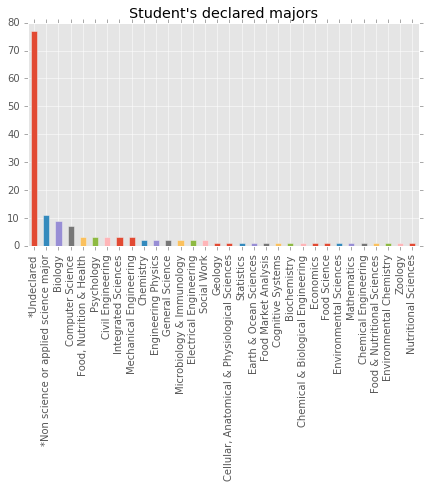

In [30]:
post_survey_df['major'].value_counts().plot.bar()
plt.title('Student\'s declared majors');

In [31]:
"There were {0} students with undeclared majors, or {1}%".format(post_survey_df['major'].value_counts()['*Undeclared'], round(post_survey_df['major'].value_counts()['*Undeclared']/float(N)*100,1))

'There were 77 students with undeclared majors, or 52.4%'

## Student prior experience

In [32]:
print "{0} ({1}%) of students have prior physics or chemistry lab experience.".format(len(set(data[data['lab_experience']==1]['sid'])), round(float(len(set(data[data['lab_experience']==1]['sid'])))/float(N),3)*100)
print "{0} ({1}%) of students have prior experience with the same or a similar sim as the Light absorbance sim.".format(len(set(data[(data['sim']=='L')&(data['similar_sim']==1)]['sid'])), round(float(len(set(data[(data['sim']=='L')&(data['similar_sim']==1)]['sid'])))/float(N),3)*100)
print "{0} ({1}%) of students have prior experience with the same or a similar sim as the Charge sim.".format(len(set(data[(data['sim']=='C')&(data['similar_sim']==1)]['sid'])), round(float(len(set(data[(data['sim']=='C')&(data['similar_sim']==1)]['sid'])))/float(N),3)*100)

132 (89.8%) of students have prior physics or chemistry lab experience.
55 (37.4%) of students have prior experience with the same or a similar sim as the Light absorbance sim.
16 (10.9%) of students have prior experience with the same or a similar sim as the Charge sim.


In [33]:
priors = list(set(data['prior_number_virtual_labs']))
t = [['Number of prior virtual labs','Number of students','Percentage']]
for prior in priors:
    t.append([prior, len(set(data[data['prior_number_virtual_labs']==prior]['sid'])), round(len(set(data[data['prior_number_virtual_labs']==prior]['sid']))/float(N)*100,1)])
print tabulate(t)
print '''where number corresponds to the following options in the survey:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)'''

----------------------------  ------------------  ----------
Number of prior virtual labs  Number of students  Percentage
0                             14                  9.5
1                             38                  25.9
2                             55                  37.4
3                             40                  27.2
----------------------------  ------------------  ----------
where number corresponds to the following options in the survey:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)


In [34]:
print "In terms of activity order, {0} students do LC and {1} students in CL".format(len(set(data[data['activity_order']=='LC']['sid'])),len(set(data[data['activity_order']=='CL']['sid'])))

In terms of activity order, 76 students do LC and 71 students in CL


## Defining incoming attitude factors
See the notebook "incoming_attributes_analysis.ipynb" for data and viz on that.

## Use of table and graph

In [35]:
print "Of all 147 students, {0} or {1}% used the table at least once.".format(sum(data['use_table']==1)/4,float(sum(data['use_table']==1))/4.0/float(N)*100)

Of all 147 students, 147 or 100.0% used the table at least once.


In [36]:
print "Of all 147 students, {0} or {1}\% used the graph at least once.".format(sum(data['use_graph']==1)/4,round(sum(data['use_graph']==1)/4.0/float(N),4)*100)

Of all 147 students, 124 or 84.35\% used the graph at least once.


In [37]:
print len(set(data[(data['use_graph']==1)&(data['cvs_graph']==1)]['sid'])), len(set(data[(data['use_graph']==1)&(data['cvs_graph']==1)]['sid']))/float(124)

97 0.782258064516


Of the 124 that use graph once, 97 or 66% use cvs_graph at least once.

In [38]:
len(set(data[data['cvs_table']==1]['sid']))/147.0

0.8367346938775511

# Results section

## Descriptives

### Learning through inquiry

Let's look at pre to post to see if students learn.

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


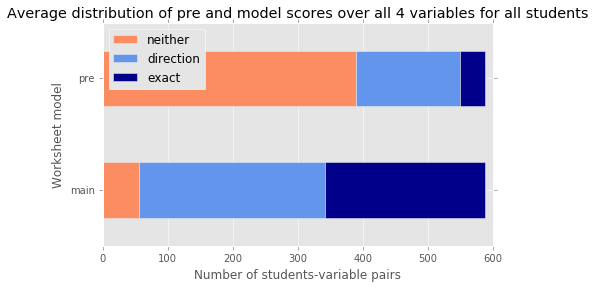

In [39]:
table = data.melt(value_vars=['pre','main'],id_vars=['variable'],var_name='type')
CMAP = ['#fc8d62','cornflowerblue','darkblue']
(table.groupby(['type','value']).count().unstack()).plot.barh(stacked=True,colors=CMAP)
plt.legend(['neither','direction','exact'],loc='upper left')
plt.xlabel("Number of students-variable pairs")
plt.ylabel("Worksheet model")
plt.title("Average distribution of pre and model scores over all {0} variables for all students".format(len(variables)));

### Broken down by variable

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


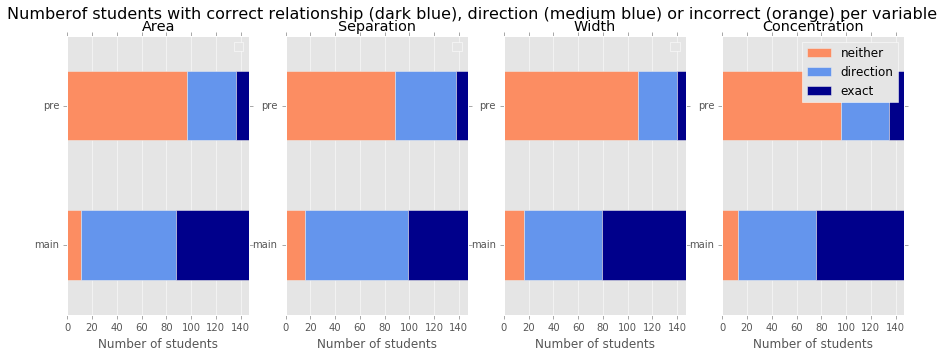

In [40]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable'],var_name='type')
CMAP = ['#fc8d62','cornflowerblue','darkblue']

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(15,5))
for j,var in enumerate(variables):
        ax=axes[j]
        subdata = table.groupby(['variable','type','value']).count().loc[(var)]
        subdata.unstack().plot.barh(ax=ax,stacked=True,colors=CMAP)
        ax.set(title=var)
        ax.set(xlabel='Number of students')
        ax.set(ylabel='')
        ax.set(xlim=(0,N))
        ax.legend([])
plt.legend(['neither','direction','exact'])
plt.suptitle('Numberof students with correct relationship (dark blue), direction (medium blue) or incorrect (orange) per variable', fontsize=16)

In [41]:
from scipy.stats import ranksums
t = [['Variable','pre score','main score','Sum of ranks','p-value','effect size']]
for variable in ['Width','Concentration','Area','Separation']:
    pm = round(np.mean(data[data["variable"]==variable]['pre']),2)
    ps = round(np.std(data[data["variable"]==variable]['pre']),2)
    mm = round(np.mean(data[data["variable"]==variable]['main']),2)
    ms = round(np.std(data[data["variable"]==variable]['main']),2)
    Z,p = ranksums(data[data["variable"]==variable]['pre'],data[data["variable"]==variable]['main'])
    eta = round(-Z/np.sqrt(N),2)
#     t.append([variable,str(pm)+'pm'+str(ps),str(mm)+'pm'+str(ms),round(Z,2),p,eta])
    t.append([variable,'$'+str(pm)+'\pm'+str(ps)+'$','$'+str(mm)+'pm'+str(ms)+'$',round(Z,2),'0.0001',eta])

print tabulate(t)
tabulate(t,tablefmt='latex')

-------------  -------------  ------------  ------------  -------  -----------
Variable       pre score      main score    Sum of ranks  p-value  effect size
Width          $0.31\pm0.56$  $1.35pm0.67$  -10.47        0.0001   0.86
Concentration  $0.43\pm0.64$  $1.39pm0.64$  -9.75         0.0001   0.8
Area           $0.41\pm0.63$  $1.33pm0.61$  -9.67         0.0001   0.8
Separation     $0.46\pm0.61$  $1.22pm0.62$  -8.39         0.0001   0.69
-------------  -------------  ------------  ------------  -------  -----------


u'\\begin{tabular}{llllll}\n\\hline\n Variable      & pre score     & main score   & Sum of ranks & p-value & effect size \\\\\n Width         & \\$0.31\\textbackslash{}pm0.56\\$ & \\$1.35pm0.67\\$ & -10.47       & 0.0001  & 0.86        \\\\\n Concentration & \\$0.43\\textbackslash{}pm0.64\\$ & \\$1.39pm0.64\\$ & -9.75        & 0.0001  & 0.8         \\\\\n Area          & \\$0.41\\textbackslash{}pm0.63\\$ & \\$1.33pm0.61\\$ & -9.67        & 0.0001  & 0.8         \\\\\n Separation    & \\$0.46\\textbackslash{}pm0.61\\$ & \\$1.22pm0.62\\$ & -8.39        & 0.0001  & 0.69        \\\\\n\\hline\n\\end{tabular}'

### Use of CVS and thus how to define it.
See viz on usage of CVS for different minimum variables and with table_consecutive and table_non_consecutive merged in the notebook *comparing_cvs_usage.ipynb*.

### CVS and pre to main model scores, by variable

In [42]:
CMAP = ['#fc8d62','cornflowerblue','darkblue']

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

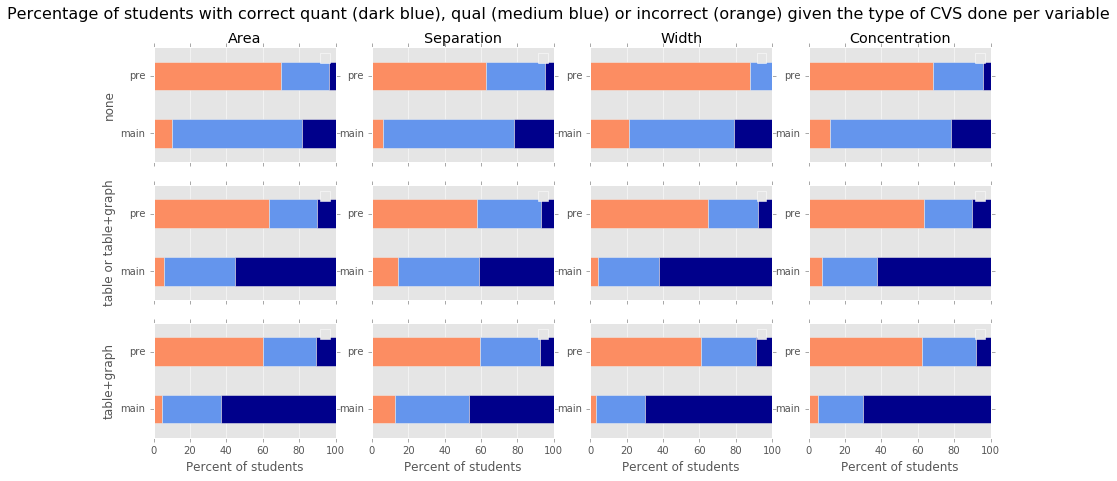

In [43]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','cvs_table','cvs_graph'],var_name='type')
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['precent students'] = subdata['sid']/N_CVS*2*100 #multiply by two because we count students once for pre and once for main
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(xlim=(0,100))
        ax.legend([])
plt.suptitle('Percentage of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done per variable', fontsize=16)

Since the above graphs show proportions fo students per model type, we cannot assess how many students are in each viz (i.e. how many students did cvs for table for the variable Separation). We redo the same graphs with number of students instead of proportions:

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

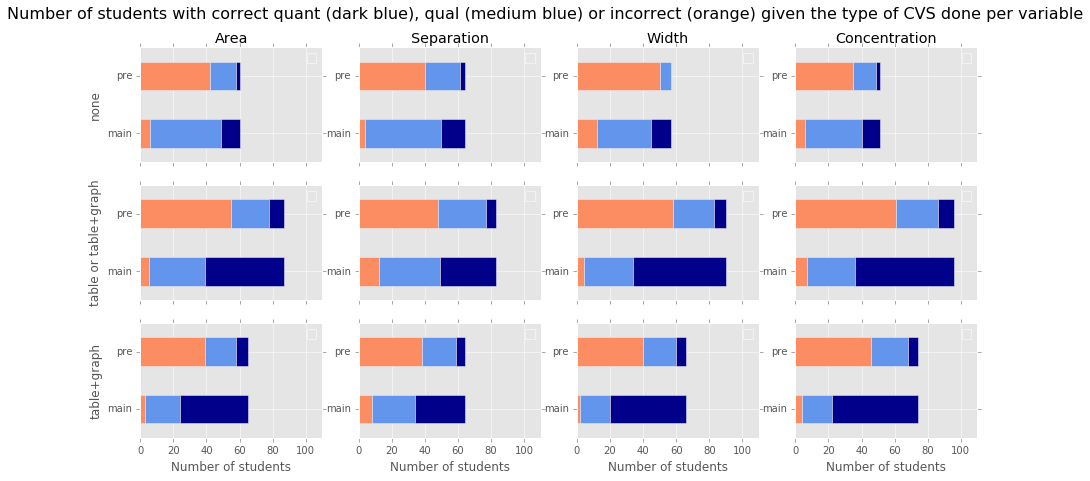

In [44]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['number students'] = subdata['sid']#/N_CVS*2*100
        subdata['number students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Number of students')
        ax.set(xlim=(0,110))
        ax.legend([])
plt.suptitle('Number of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done per variable', fontsize=16)

There are several things to notice:
* For each variable, about 50-60 students don't do CVS.
* The odd of doing different CVS or not doesn't change much by variable
* We can see that the profile of pre models doesn't change much by variable nor by what CVS was done.
* Most students do cvs_table
* Doing cvs_table clearly helps a little to get a quantitative model (slightly less for Separation).
* Doing cvs_graph clearly helps a lot (slightly less for Separation).

### Same graph but only main and with table_only

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

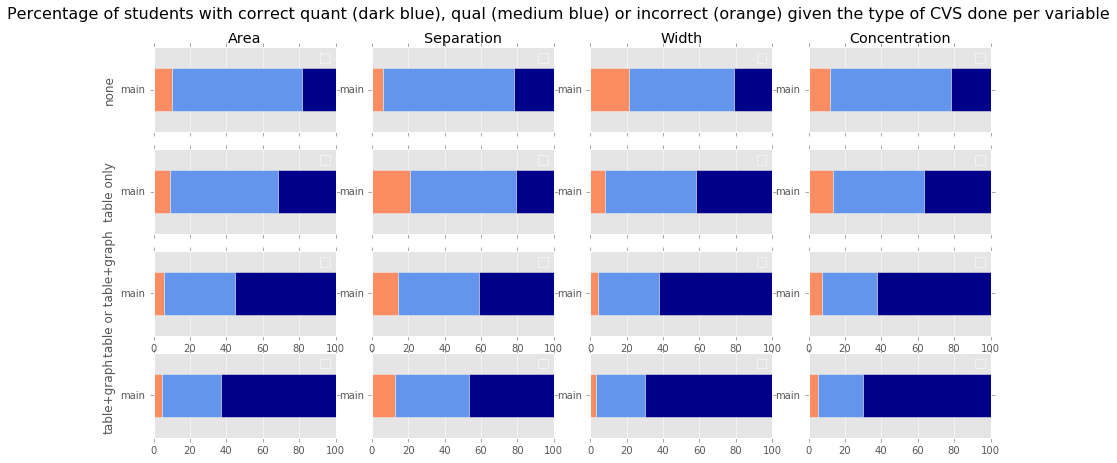

In [45]:
table = data.melt(value_vars=['main'],id_vars=['sid','variable',"cvs_table_only",'cvs_table','cvs_graph'],var_name='type')
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,"cvs_table_only",'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['precent students'] = subdata['sid']/N_CVS*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table_only":"table only","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(xlim=(0,100))
        ax.legend([])
plt.suptitle('Percentage of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done per variable', fontsize=16)

### CVS and main as a table

In [46]:
t = [['Variable','None','CVS-table','CVS-plot']]
for variable in ['Width','Concentration','Area','Separation']:
    t.append([variable, str(data[(data["variable"]==variable)&(data["cvs_table"]==0)].shape[0])+
                          ' ('+str(round(data[(data["variable"]==variable)&(data["cvs_table"]==0)].shape[0]/float(N)*100,1))+'%)',
                          str(data[(data["variable"]==variable)]["cvs_table"].sum())+
                          ' ('+str(round(data[(data["variable"]==variable)]["cvs_table"].sum()/float(N)*100,1))+'%)',
                          str(data[(data["variable"]==variable)]["cvs_graph"].sum())+
                          ' ('+str(round(data[(data["variable"]==variable)]["cvs_graph"].sum()/float(N)*100,1))+'%)',])
#     pm = round(np.mean(scores.loc[variable]['pre']),2)
#     ps = round(np.std(scores.loc[variable]['pre']),2)
#     mm = round(np.mean(scores.loc[variable]['main']),2)
#     ms = round(np.std(scores.loc[variable]['main']),2)
#     Z,p = ranksums(scores.loc[variable]['pre'],scores.loc[variable]['main'])
#     eta = round(-Z/np.sqrt(N),2)
# #     t.append([variable,str(pm)+'pm'+str(ps),str(mm)+'pm'+str(ms),round(Z,2),p,eta])
#     t.append([variable,'$'+str(pm)+'\pm'+str(ps)+'$','$'+str(mm)+'pm'+str(ms)+'$',round(Z,2),'0.0001',eta])

print tabulate(t)
print tabulate(t,tablefmt='latex')

-------------  ----------  ----------  ----------
Variable       None        CVS-table   CVS-plot
Width          57 (38.8%)  90 (61.2%)  66 (44.9%)
Concentration  51 (34.7%)  96 (65.3%)  74 (50.3%)
Area           60 (40.8%)  87 (59.2%)  65 (44.2%)
Separation     64 (43.5%)  83 (56.5%)  64 (43.5%)
-------------  ----------  ----------  ----------
\begin{tabular}{llll}
\hline
 Variable      & None       & CVS-table  & CVS-plot   \\
 Width         & 57 (38.8\%) & 90 (61.2\%) & 66 (44.9\%) \\
 Concentration & 51 (34.7\%) & 96 (65.3\%) & 74 (50.3\%) \\
 Area          & 60 (40.8\%) & 87 (59.2\%) & 65 (44.2\%) \\
 Separation    & 64 (43.5\%) & 83 (56.5\%) & 64 (43.5\%) \\
\hline
\end{tabular}


### Transfer items

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

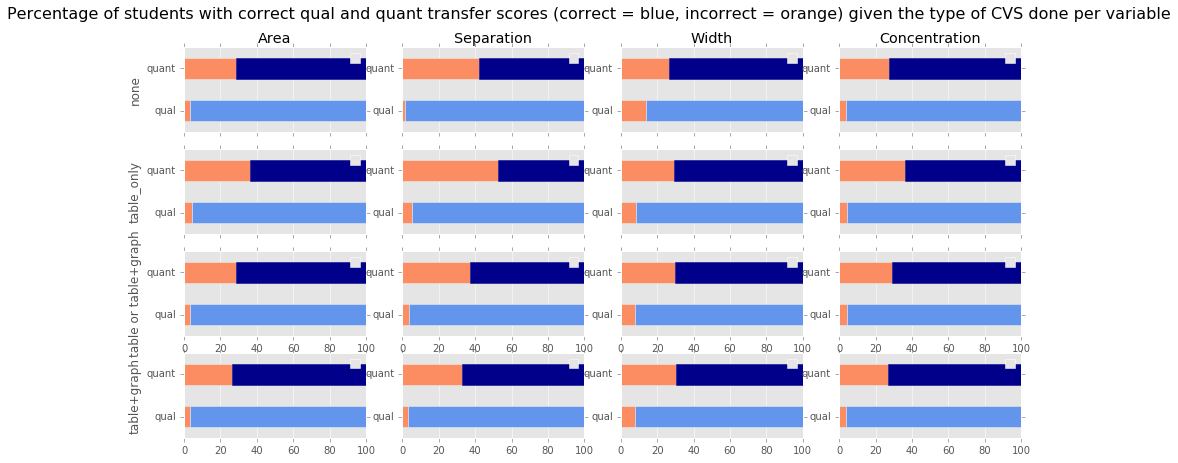

In [47]:
table = data.melt(value_vars=['qual_score','quant_score'],id_vars=['sid','variable','cvs_table_only','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,'cvs_table_only','cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['precent students'] = subdata['sid']/N_CVS*2*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none",'cvs_table_only':'table_only',"cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(yticklabels = ['qual','quant'])
        ax.set(xlim=(0,100))
        ax.legend([])
        bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
        bars[3].set_color(CMAP[2])
plt.suptitle('Percentage of students with correct qual and quant transfer scores (correct = blue, incorrect = orange) given the type of CVS done per variable', fontsize=16)


We notice the following:
* Qual trasnfer items are near ceiling. Only the variable "Width" gets 5-15% of students confused, perhaps for the same reason many students have an incorrect pre model for Width (because of the confusion between absorbance and transmission).
* Quant transfer increase slightly when students to CVS but by no more than 5%. Thus we do not expect our stats models to have CVS as a significant variable.

### Interaction with pre

We want to know if we should include interactions in our stats. Specifically *CVS_graph x variable* and *CVS_graph x pre* (same thing for CVS_table). We can evaluate the first with the graphs abve. For the later, we make the following plot.

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

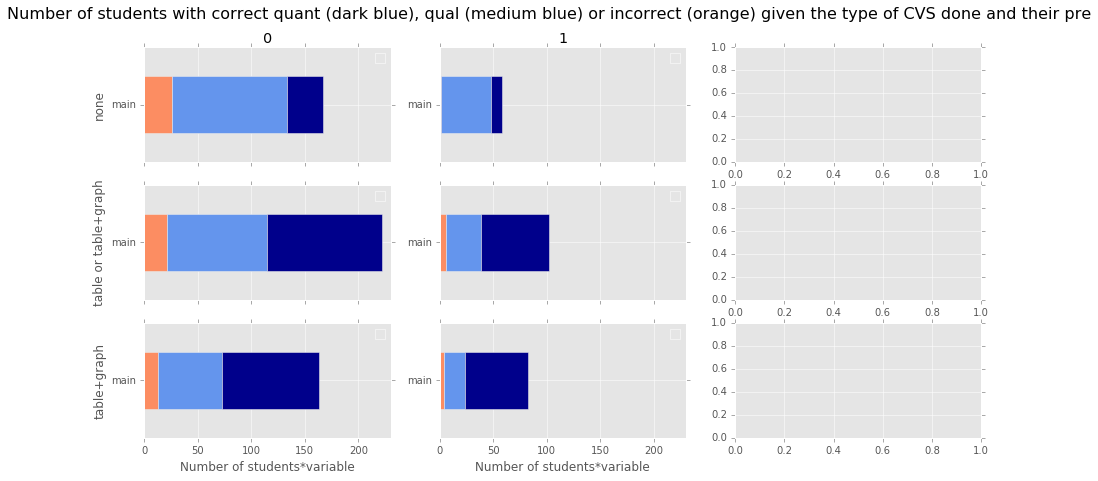

In [48]:
table = data.melt(value_vars=['main'],id_vars=['sid','pre','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(15,7))
for j,pre_val in enumerate([0,1]):
    for i,cvs in enumerate([0,'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','pre','type','value']).count().loc[(0,pre_val)]
        else:
            subdata = table.groupby([cvs,'pre','type','value']).count().loc[(1,pre_val)]
        N_CVS = subdata['sid'].sum()
        subdata['number students'] = subdata['sid']#/N_CVS*2*100
        if 0 in subdata.index.labels[1]:
            subdata['number students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        else:
            subdata['number students'].unstack().plot.barh(ax=ax,colors=CMAP[1:],stacked=True)
        if i==0:
            ax.set(title=pre_val)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Number of students*variable')
        ax.set(xlim=(0,230))
        ax.legend([])
plt.suptitle('Number of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done and their pre', fontsize=16)

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

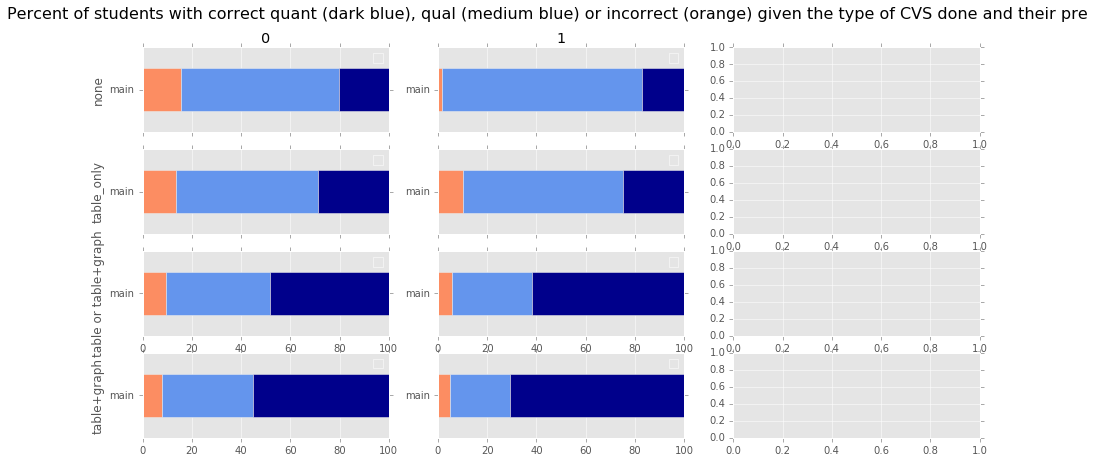

In [49]:
table = data.melt(value_vars=['main'],id_vars=['sid','pre','cvs_table_only','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(15,7))
for j,pre_val in enumerate([0,1]):
    for i,cvs in enumerate([0,'cvs_table_only','cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','pre','type','value']).count().loc[(0,pre_val)]
        else:
            subdata = table.groupby([cvs,'pre','type','value']).count().loc[(1,pre_val)]
        N_CVS = subdata['sid'].sum()
        subdata['number students'] = subdata['sid']/N_CVS*100
        if 0 in subdata.index.labels[1]:
            subdata['number students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        else:
            subdata['number students'].unstack().plot.barh(ax=ax,colors=CMAP[1:],stacked=True)
        if i==0:
            ax.set(title=pre_val)
        if j==0:
            ax.set(ylabel={0:"none",'cvs_table_only':'table_only',"cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students*variable')
        ax.set(xlim=(0,100))
        ax.legend([])
plt.suptitle('Percent of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done and their pre', fontsize=16)

## Stats model 1 predicting main -  post-hocs

### post-hoc for cvs_table


D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


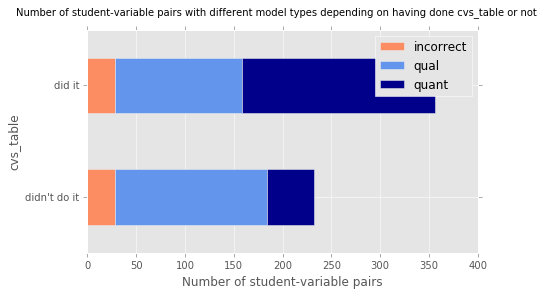

In [50]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['cvs_table','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student-variable pairs')
ax.set(yticklabels = ['didn\'t do it', 'did it'])
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student-variable pairs with different model types depending on having done cvs_table or not')

### post-hoc for cvs_graph

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


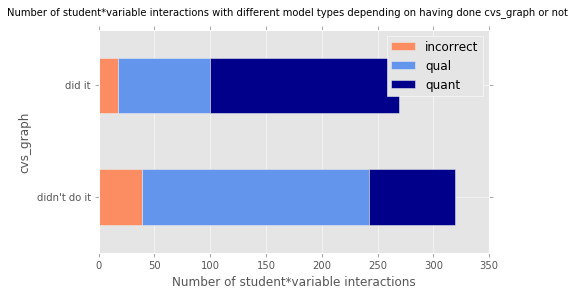

In [51]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['cvs_graph','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.set(yticklabels = ['didn\'t do it', 'did it'])
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student*variable interactions with different model types depending on having done cvs_graph or not')

### post-hoc for sim_index

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


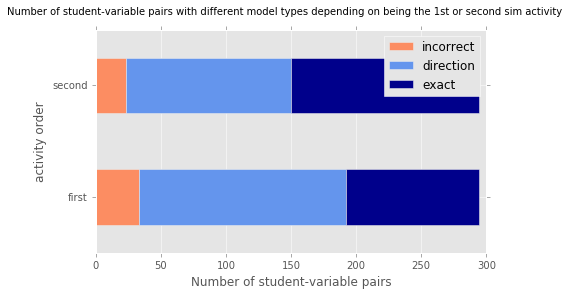

In [52]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['sim_index','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student-variable pairs')
ax.set(ylabel='activity order')
ax.set(yticklabels = ['first','second'])
ax.legend(['incorrect','direction','exact'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student-variable pairs with different model types depending on being the 1st or second sim activity')

### Post-hoc by variable

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


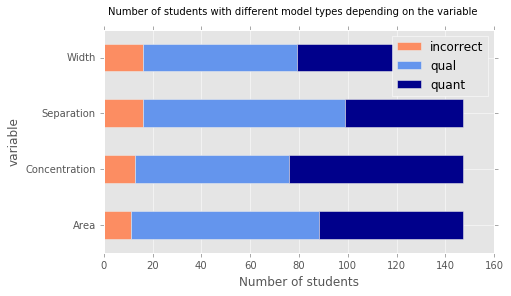

In [53]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['variable','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of students')
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of students with different model types depending on the variable')

## Stats model 2 predicting tests - post-hocs

### post-hoc for main

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


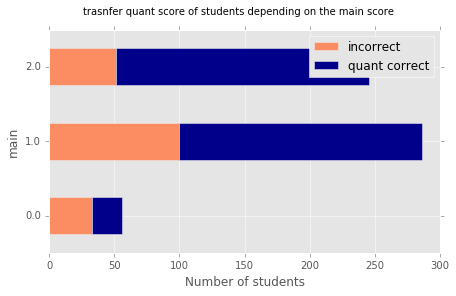

In [54]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['main','quant_score']).count()['sid'].unstack().plot.barh(stacked=True,colors=[CMAP[0],CMAP[2]],ax=ax)
ax.set(xlabel='Number of students')
ax.legend(['incorrect','quant correct'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('trasnfer quant score of students depending on the main score')

### post-hoc for variable

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


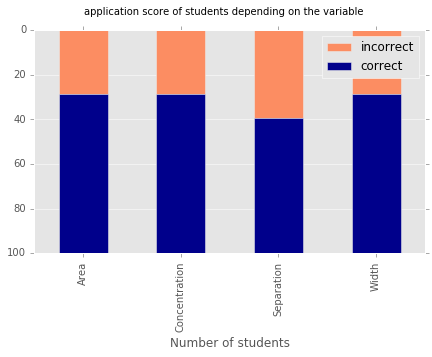

In [55]:
fig,ax = plt.subplots(nrows=1,ncols=1)
(data.groupby(['variable','quant_score']).count()['sid'].unstack()/float(N)*100).plot.bar(stacked=True,colors=[CMAP[0],CMAP[2]],ax=ax)
ax.set(xlabel='Number of students')
ax.legend(['incorrect','correct'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('application score of students depending on the variable')
plt.gca().invert_yaxis()

In [56]:
data.groupby(['variable','quant_score']).count()['sid'].unstack()

quant_score,0.0,1.0
variable,,
Area,42,105
Concentration,42,105
Separation,58,89
Width,42,105


### post-hoc for pre

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


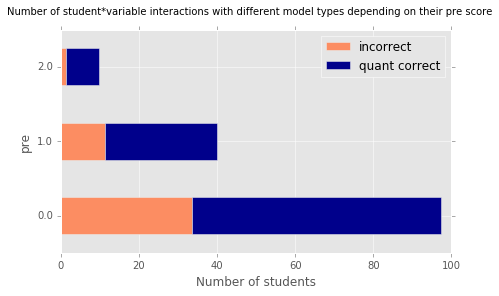

In [57]:
fig,ax = plt.subplots(nrows=1,ncols=1)
(data.groupby(['pre','quant_score']).count()['sid'].unstack()/len(variables)).plot.barh(stacked=True,colors=[CMAP[0],CMAP[2]],ax=ax)
ax.set(xlabel='Number of students')
ax.legend(['incorrect','quant correct'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student*variable interactions with different model types depending on their pre score')

## Stats model 3 predicting cvs usage - post-hocs

### Post-hoc for sim_index and cvs_graph

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


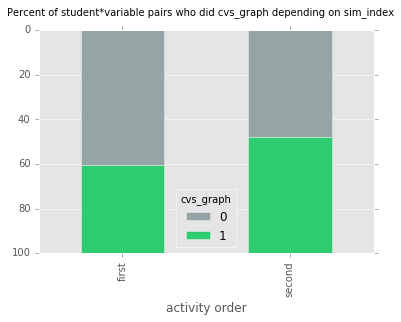

In [58]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
(data.groupby(['sim_index','cvs_graph']).count()['sid'].unstack()/float(2*N)*100).plot.bar(stacked=True,colors=["#95a5a6","#2ecc71"],ax=ax)
ax.set(xlabel='activity order')
ax.set(xticklabels = ['first','second'])
plt.suptitle('Percent of student*variable pairs who did cvs_graph depending on sim_index')
plt.gca().invert_yaxis()

### post-hoc table_only and sim_index

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


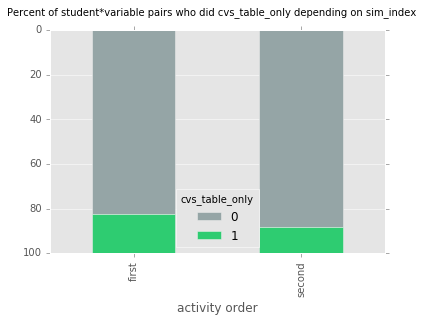

In [59]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
(data.groupby(['sim_index','cvs_table_only']).count()['sid'].unstack()/float(2*N)*100).plot.bar(stacked=True,colors=["#95a5a6","#2ecc71"],ax=ax)
ax.set(xlabel='activity order')
ax.set(xticklabels = ['first','second'])
plt.suptitle('Percent of student*variable pairs who did cvs_table_only depending on sim_index')
plt.gca().invert_yaxis()

### Post-hoc for lab experience

In [60]:
table = data.groupby(['lab_experience','cvs_graph']).count()['sid'].unstack()/len(variables)
table['0.'] = table[0]/(table[0]+table[1])*100
table['1.'] = table[1]/(table[0]+table[1])*100
table = table[['0.','1.']]

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


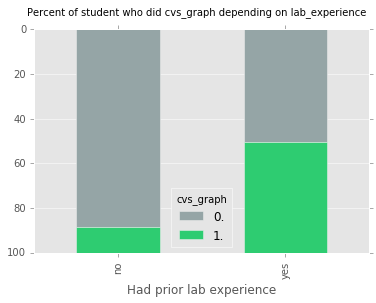

In [61]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
table.plot.bar(stacked=True,colors=["#95a5a6","#2ecc71"],ax=ax)
ax.set(xlabel='Had prior lab experience')
ax.set(xticklabels = ['no','yes'])
# ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Percent of student who did cvs_graph depending on lab_experience')
plt.gca().invert_yaxis()

### post hoc for pre

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


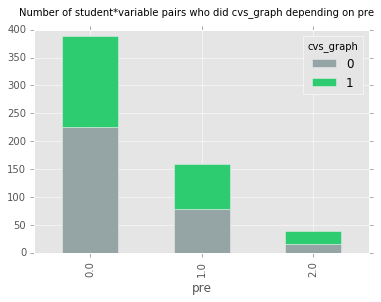

In [62]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
(data.groupby(['pre','cvs_graph']).count()['sid'].unstack()).plot.bar(stacked=True,colors=["#95a5a6","#2ecc71"],ax=ax)
plt.suptitle('Number of student who did cvs_graph depending on sim_index')
# ax.set(xlabel='pre')
plt.suptitle('Number of student*variable pairs who did cvs_graph depending on pre')

In [63]:
table = data.groupby(['pre','cvs_graph']).count()['sid'].unstack()
table['0.'] = table[0]/(table[0]+table[1])*100
table['1.'] = table[1]/(table[0]+table[1])*100
table = table[['0.','1.']]

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


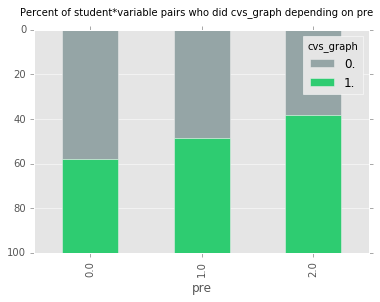

In [64]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
(table).plot.bar(stacked=True,colors=["#95a5a6","#2ecc71"],ax=ax)
# plt.suptitle('Number of student who did cvs_graph depending on sim_index')
ax.set(xlabel='pre')
plt.suptitle('Percent of student*variable pairs who did cvs_graph depending on pre')
plt.gca().invert_yaxis()

### Post hoc for virtual_lab_expreince and cvs_table

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


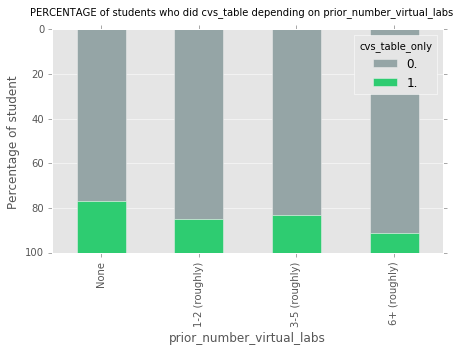

In [65]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
df = data.groupby(['prior_number_virtual_labs','cvs_table_only']).count()['sid'].unstack()/len(variables)
df['sum']=df[0]+df[1]
df['0.']=df[0]/df['sum']*100
df['1.']=df[1]/df['sum']*100
df[['0.','1.']].plot.bar(stacked=True,colors=["#95a5a6","#2ecc71"],ax=ax)
ax.set(ylabel='Percentage of student')
ax.set(xticklabels = ["None", "1-2 (roughly)", "3-5 (roughly)", "6+ (roughly)"])
plt.suptitle('PERCENTAGE of students who did cvs_table depending on prior_number_virtual_labs')
plt.gca().invert_yaxis()

### post-hoc cvs_graph_inverse and variable

In [66]:
data.columns

Index([u'sid', u'sim', u'variable', u'pre', u'main', u'cvs_graph', u'cvs_table', u'cvs_table_only',
       u'cvs_graph_inverse', u'cvs_graph_axes', u'qual_score', u'quant_score', u'activity_order',
       u'sim_index', u'similar_sim', u'lab_experience', u'prior_number_virtual_labs',
       u'overall POCC', u'PC1', u'PC2', u'pre_with_ident', u'main_with_ident', u'CVS_context',
       u'use_table', u'use_graph', u'use_concentration', u'use_width', u'use_area',
       u'use_separation', u'use_all_vars', u'use_graph_beers', u'use_table_beers',
       u'use_table_capacitor', u'use_graph_capacitor'],
      dtype='object')

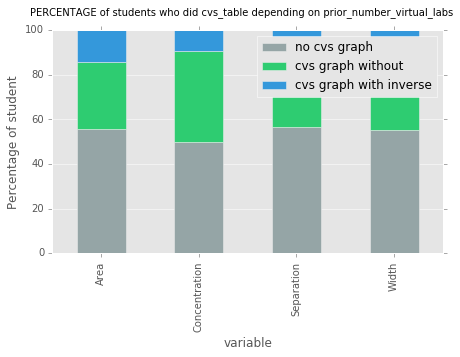

In [67]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
df = data.groupby(['variable','cvs_graph_axes']).count()['sid'].unstack()/float(N)*100
df.plot.bar(stacked=True,ax=ax,color=["#95a5a6","#2ecc71","#3498db"])
ax.set(ylabel='Percentage of student')
plt.suptitle('PERCENTAGE of students who did cvs_table depending on prior_number_virtual_labs')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['no cvs graph','cvs graph without','cvs graph with inverse'])
# plt.gca().invert_yaxis()

### Comparing use of graph 1st and second sim

In [68]:
data[['sim_index','sim','use_graph_beers','use_table_beers','use_table_capacitor','use_graph_capacitor']].groupby(['sim','sim_index']).sum()

use_graph_beers  use_table_beers  use_table_capacitor  use_graph_capacitor
sim sim_index                                                                            
C   1                      110              130                  130                   78
    2                      124              150                  144                  114
L   1                      124              150                  144                  114
    2                      110              130                  130                   78

In [69]:
(78+124)/2.0/148.0

0.6824324324324325

In [70]:
(114+110)/2.0/148.0

0.7567567567567568

For capacitance sim, the use of the graph, goes from 55% to 75% from 1st to 2nd sim.

For beers sim, the use of the graph, goes from 82% to 76% from 1st to 2nd sim.

The use of the table is always above 90%.

Note that using the graph means both axes are defined and 1 point added.

## Investigating why main matters but not CVS

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

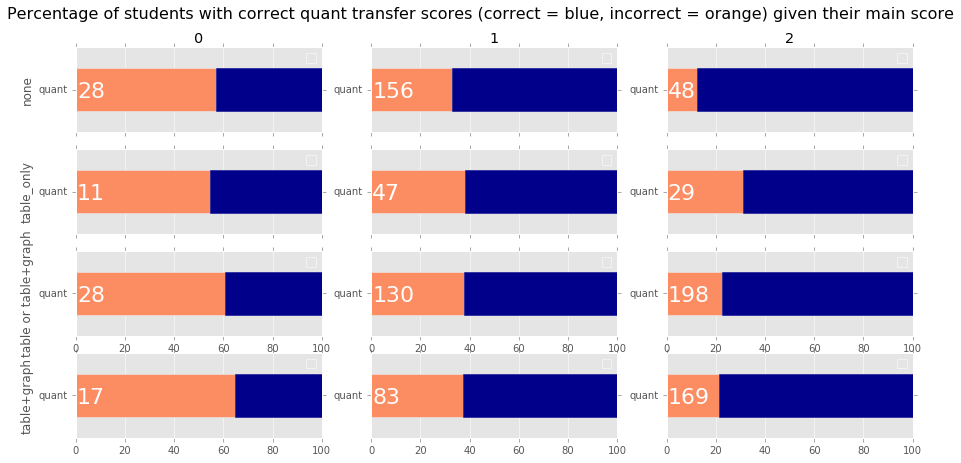

In [71]:
table = data.melt(value_vars=['quant_score'],id_vars=['sid','main','cvs_table_only','cvs_table','cvs_graph'],var_name='type')
totals=0
fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(15,7))
for j,var in enumerate([0,1,2]):
    for i,cvs in enumerate([0,'cvs_table_only','cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','main','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'main','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        if cvs !='cvs_table':
            totals += N_CVS
        subdata['precent students'] = subdata['sid']/N_CVS*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none",'cvs_table_only':'table_only',"cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(yticklabels = ['quant'])
        ax.set(xlim=(0,100))
        ax.legend([])
        bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
        bars[1].set_color(CMAP[2])
        ax.text(ax.patches[0].get_x()+0.5, ax.patches[0].get_height()-0.6,str(N_CVS), fontsize=22,color='white')
plt.suptitle('Percentage of students with correct quant transfer scores (correct = blue, incorrect = orange) given their main score', fontsize=16)

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being dep

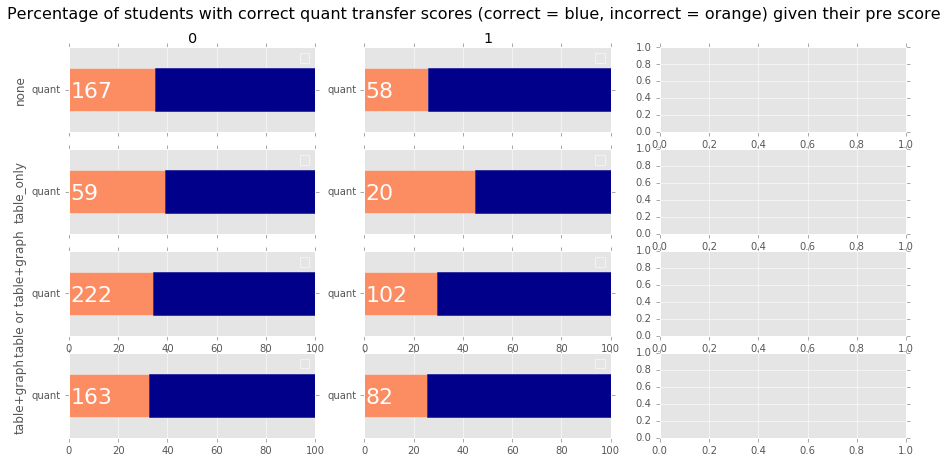

In [72]:
table = data.melt(value_vars=['quant_score'],id_vars=['sid','pre','cvs_table_only','cvs_table','cvs_graph'],var_name='type')
totals=0
fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(15,7))
for j,var in enumerate([0,1]):
    for i,cvs in enumerate([0,'cvs_table_only','cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','pre','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'pre','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        if cvs !='cvs_table':
            totals += N_CVS
        subdata['precent students'] = subdata['sid']/N_CVS*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
#         print var, cvs, subdata
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none",'cvs_table_only':'table_only',"cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(yticklabels = ['quant'])
        ax.set(xlim=(0,100))
        ax.legend([])
        bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
        bars[1].set_color(CMAP[2])
        ax.text(ax.patches[0].get_x()+0.5, ax.patches[0].get_height()-0.6,str(N_CVS), fontsize=22,color='white')
plt.suptitle('Percentage of students with correct quant transfer scores (correct = blue, incorrect = orange) given their pre score', fontsize=16)


## Line graphs

### cvs_graph vs. pre

In [73]:
table = data.melt(value_vars=['main'],id_vars=['sid','pre','cvs_table_only','cvs_table','cvs_graph'],var_name='type')

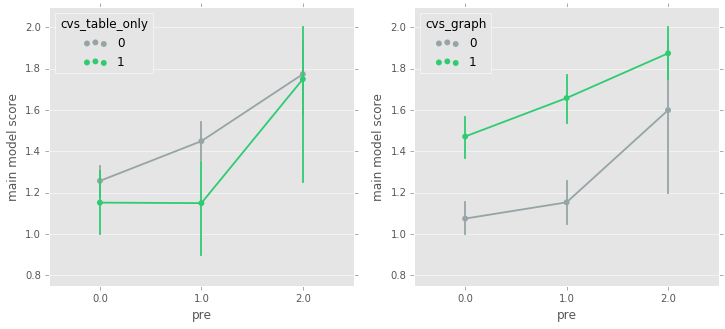

In [74]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
for i,cvs_type in enumerate(["cvs_table_only","cvs_graph"]):
    ax = axes[i]
    sns.pointplot(x="pre", y="value", hue=cvs_type, data=table, ax=ax, palette=["#95a5a6","#2ecc71"],)
    ax.set(ylim = (0.75,2.1))
    ax.set(ylabel="main model score")

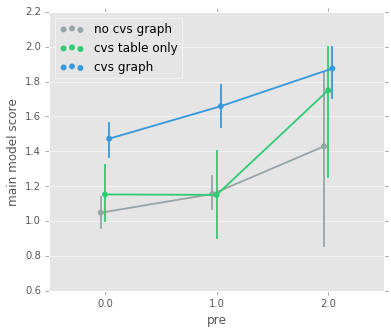

In [96]:
table = data.melt(value_vars=['main'],id_vars=['sid','pre','CVS_context'],var_name='type')
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
sns.pointplot(x="pre", y="value", hue='CVS_context', data=table, ax=ax, dodge=True, palette=["#95a5a6","#2ecc71","#3498db"])
# ax.set(ylim = (0.75,2.1))
ax.set(ylabel="main model score")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['no cvs graph','cvs table only','cvs graph'],loc='upper left')

In [99]:
table.pivot_table(aggfunc=len, values='sid',columns='pre', index='CVS_context')

pre,0.0,1.0,2.0
CVS_context,,,
0,167,58,7
1,59,20,8
2,163,82,24


### cvs vs. variable

In [75]:
table = data.melt(value_vars=['main'],id_vars=['sid','variable','sim_index','pre','cvs_table','cvs_graph'],var_name='type')

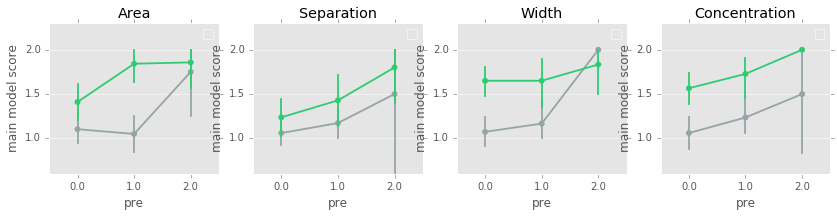

In [76]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(14,2.7))
for i,var in enumerate(variables):
    ax = axes[i]
    sns.pointplot(x="pre", y="value", hue="cvs_graph", data=table[table['variable']==var], ax=ax, palette=["#95a5a6","#2ecc71"])
    ax.set(ylim = (0.6,2.3))
    ax.set(ylabel="main model score")
    ax.set(title=var)
    ax.legend([])

### cvs graph inverse and Separation

In [77]:
table = data.melt(value_vars=['main'],id_vars=['sid','variable','sim_index','pre','cvs_graph_axes'],var_name='type')

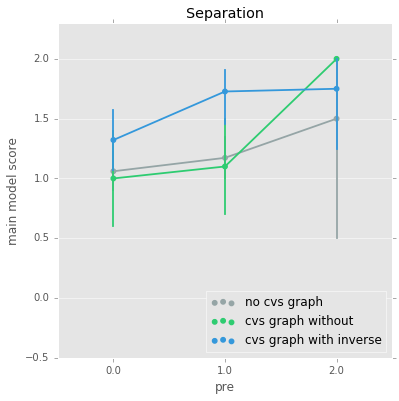

In [78]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
sns.pointplot(x="pre", y="value", hue="cvs_graph_axes", data=table[table['variable']=='Separation'], ax=ax, palette=["#95a5a6","#2ecc71","#3498db"])
ax.set(ylim = (-0.5,2.3))
ax.set(ylabel="main model score")
ax.set(title='Separation')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['no cvs graph','cvs graph without','cvs graph with inverse'],loc='lower right')

In [79]:
nn= data[(data['variable']=='Separation')&(data['cvs_graph_inverse']==1)]['sid'].count()
dd = data[(data['variable']=='Separation')&(data['cvs_graph']==1)]['sid'].count()
print nn,dd, nn/float(dd)

43 64 0.671875


67% of students who do cvs_graph for Separation do so with an inverse scale, at some point.

In [80]:
data[(data['variable']=='Separation')&(data['cvs_graph_inverse']==0)&(data['cvs_graph']==0)&(data['pre']==2)]['sid'].count()

4

In [81]:
data[(data['variable']=='Separation')&(data['pre']==2)]['sid'].count()

9

That green dot that has pre=2 and didn't do cvs_graph with inverse for Separation represents 1 student. Only 9 students had pre=2 for Separation.

### sim_index

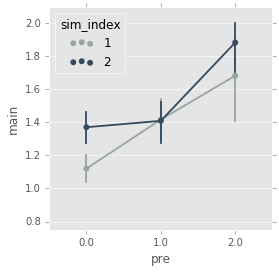

In [82]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
sns.pointplot(x="pre", y="value", hue='sim_index', data=table, ax=ax, palette=["#95a5a6","#34495e"])
ax.set(ylim = (0.75,2.1))
ax.set(ylabel="main")

### transfer and variable

In [83]:
table = data.melt(value_vars=['quant_score'],id_vars=['sid','variable','sim_index','pre','cvs_table','cvs_graph'],var_name='type')

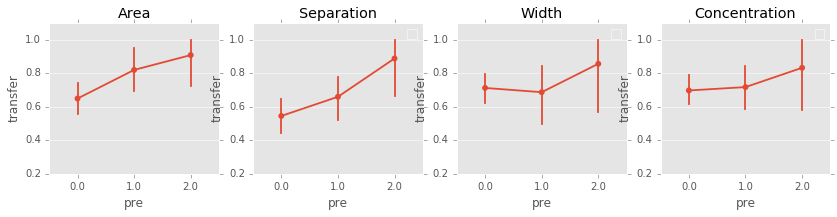

In [84]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(14,2.7))
for i,var in enumerate(variables):
    ax = axes[i]
    sns.pointplot(x="pre", y="value", data=table[table['variable']==var], ax=ax)
    ax.set(ylim = (0.2,1.1))
    ax.set(ylabel="transfer")
    ax.set(title=var)
    if i>0:ax.legend([])

### transfer and cvs_inverse for separation

In [85]:
table = data.melt(value_vars=['quant_score'],id_vars=['sid','variable','sim_index','pre','cvs_graph_axes'],var_name='type')

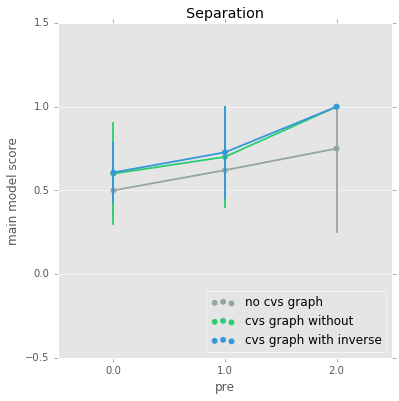

In [86]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
sns.pointplot(x="pre", y="value", hue="cvs_graph_axes", data=table[table['variable']=='Separation'], ax=ax, palette=["#95a5a6","#2ecc71","#3498db"])
ax.set(ylim = (-0.5,1.5))
ax.set(ylabel="main model score")
ax.set(title='Separation')
# ax.legend(handles=['none','1','2'],loc='lower right')#,labels=['none','1','2'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['no cvs graph','cvs graph without','cvs graph with inverse'],loc='lower right')

### transfer by cvs

In [87]:
table = data.melt(value_vars=['quant_score'],id_vars=['sid','variable','sim_index','pre','cvs_table_only','cvs_graph'],var_name='type')

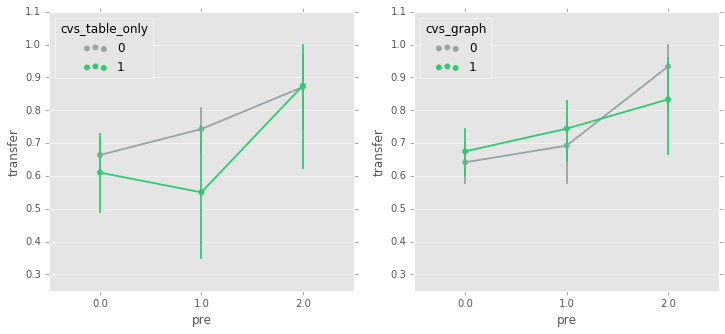

In [88]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
for i,cvs_type in enumerate(["cvs_table_only","cvs_graph"]):
    ax = axes[i]
    sns.pointplot(x="pre", y="value", hue=cvs_type, data=table, ax=ax, palette=["#95a5a6","#2ecc71"])
    ax.set(ylim = (0.25,1.1))
    ax.set(ylabel="transfer")